In [28]:
# -*- coding: utf-8 -*-
"""Assignment_2_Part_1_Cifar10_vp1.ipynb

Purpose: Implement image classsification nn the cifar10
dataset using a pytorch implementation of a CNN architecture (LeNet5)

Pseudocode:
1) Set Pytorch metada
- seed
- tensorboard output (logging)
- whether to transfer to gpu (cuda)

2) Import the data
- download the data
- create the pytorch datasets
    scaling
- create pytorch dataloaders
    transforms
    batch size

3) Define the model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates
        f. Calculate accuracy, other stats
    - Test:
        a. Calculate loss, accuracy, other stats

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop




"""

# Step 1: Pytorch and Training Metadata

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path

#hyperparameters
batch_size = 128
epochs = 10
lr = 0.001
try_cuda = True
seed = 1000

# Architecture
num_classes = 10

#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = True

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

"""# Step 2: Data Setup"""

# downloading the cifar10 dataset


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(test_loader)

"""# 3) Creating the Model"""

layer_1_n_filters = 32
layer_2_n_filters = 64
fc_1_n_nodes = 1024
padding="same"
padding = (kernel_size - 1) // 2
kernel_size = 5
verbose = False


conv1_output_size = (32 + 2*padding - kernel_size) / 1 + 1  # convolution 1
pool1_output_size = conv1_output_size / 2  # maxpool 1
conv2_output_size = (pool1_output_size + 2*padding - kernel_size) / 1 + 1  # convolution 2
pool2_output_size = conv2_output_size / 2  # maxpool 2


final_length = int(pool2_output_size)


if verbose:
    print(f"final_length = {final_length}")


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(

            nn.Conv2d(1, layer_1_n_filters, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(layer_1_n_filters, layer_2_n_filters, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(final_length*final_length*layer_2_n_filters*in_channels, fc_1_n_nodes),
            nn.Tanh(),
            nn.Linear(fc_1_n_nodes, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        logits = self.classifier(x)  
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
model = LeNet5(num_classes=num_classes, grayscale=grayscale)

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

"""# Step 4: Train/Test Loop"""

# Defining the test and trainig loops

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        logits, probas = model(data)  # forward
        
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = logits.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    acc = 100.*correct/total
    print(f'Train Epoch: {epoch}, Loss: {train_loss:.4f}, Accuracy: {acc:.2f}%')

    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Accuracy', acc, epoch)

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()

            logits, probas = model(data)
            
            loss = criterion(logits, target)
            test_loss += loss.item()
            
            _, predicted = logits.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    acc = 100.*correct/total
    print(f'Test Epoch: {epoch}, Loss: {test_loss:.4f}, Accuracy: {acc:.2f}%')
    
    writer.add_scalar('Test/Loss', test_loss, epoch)
    writer.add_scalar('Test/Accuracy', acc, epoch)


for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    print('finish epoch',epoch)


writer.close()




Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])
Train Epoch: 1, Loss: 600.9244, Accuracy: 45.60%
Test Epoch: 1, Loss: 103.8577, Accuracy: 53.29%
finish epoch 1
Train Epoch: 2, Loss: 472.0545, Accuracy: 57.89%
Test Epoch: 2, Loss: 93.8144, Accuracy: 58.91%
finish epoch 2
Train Epoch: 3, Loss: 425.8048, Accuracy: 62.03%
Test Epoch: 3, Loss: 89.6639, Accuracy: 60.43%
finish epoch 3
Train Epoch: 4, Loss: 396.5062, Accuracy: 65.00%
Test Epoch: 4, Loss: 86.9111, Accuracy: 61.95%
finish epoch 4
Train Epoch: 5, Loss: 372.0275, Accuracy: 67.10%
Test Epoch: 5, Loss: 83.8234, Accuracy: 63.82%
finish epoch 5
Train Epoch: 6, Loss: 357.7390, Accuracy: 68.29%
Test Epoch: 6, Loss: 81.7399, Accuracy: 64.41%
finish epoch 6
Train Epoch: 7, Loss: 341.8187, Accuracy: 69.81%
Test Epoch: 7, Los

In [29]:
%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
%tensorboard --logdir runs

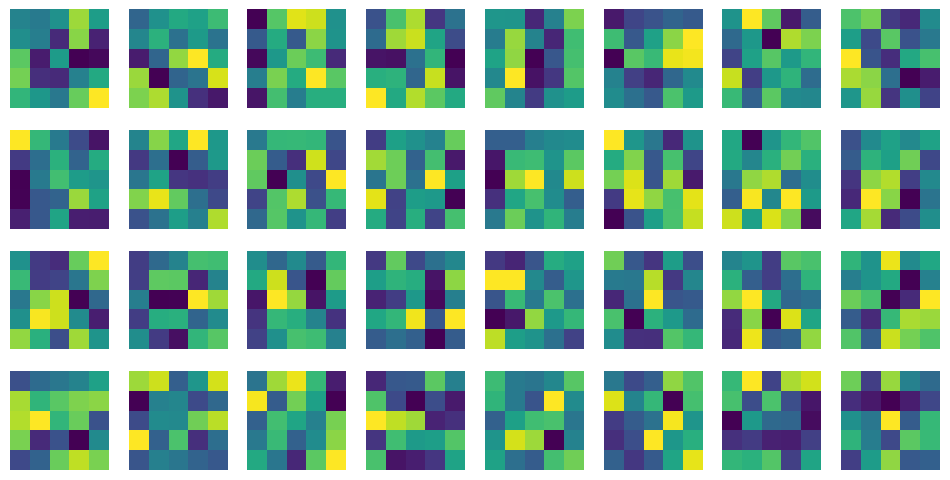

In [32]:
import matplotlib.pyplot as plt


first_conv_layer = model.features[0] 


weights = first_conv_layer.weight.data.cpu()


fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(4):
    for j in range(8):
        ax = axs[i, j]
        ax.imshow(weights[i * 8 + j].permute(1, 2, 0))
        ax.axis('off')
plt.show()


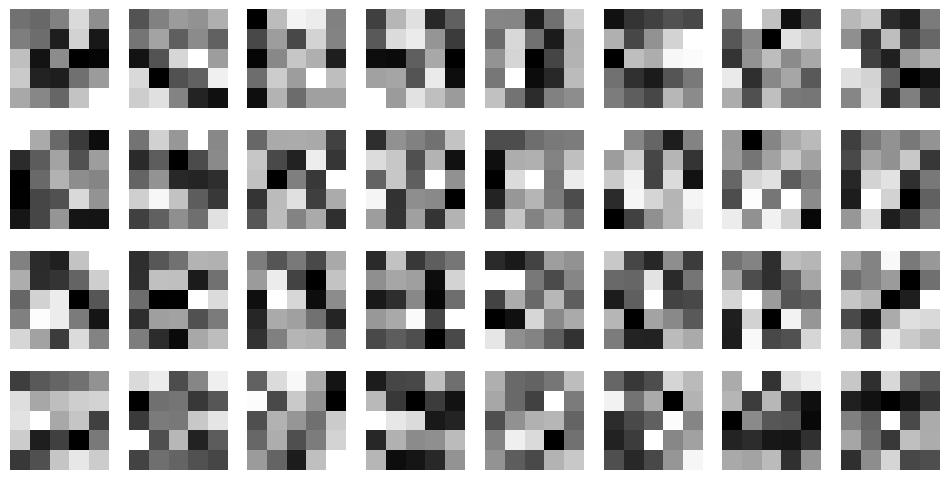

In [33]:
import matplotlib.pyplot as plt


first_conv_layer = model.features[0]  


weights = first_conv_layer.weight.data.cpu()

# Visualize the weights
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(4):
    for j in range(8):
        ax = axs[i, j]
        ax.imshow(weights[i * 8 + j][0], cmap='gray') 
        ax.axis('off')
plt.show()

In [35]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



# Create hooks to collect activations
activation_stats = []

def hook_fn(module, input, output):
    activation_stats.append(output)


hook1 = model.features[0].register_forward_hook(hook_fn)  
hook2 = model.features[3].register_forward_hook(hook_fn)  


model.eval()


with torch.no_grad():
    for data, target in test_loader:
        if cuda:
            data = data.cuda()
        output = model(data)
        break  

# Remove hooks
hook1.remove()
hook2.remove()


for i, activation in enumerate(activation_stats):
    mean_activation = activation.mean().item()
    std_activation = activation.std().item()
    max_activation = activation.max().item()
    min_activation = activation.min().item()
    
    print(f"Conv Layer {i + 1}:")
    print(f"Mean activation: {mean_activation:.2f}")
    print(f"Std activation: {std_activation:.2f}")
    print(f"Max activation: {max_activation:.2f}")
    print(f"Min activation: {min_activation:.2f}")
    print("-" * 50)

Conv Layer 1:
Mean activation: -0.07
Std activation: 0.18
Max activation: 1.68
Min activation: -1.77
--------------------------------------------------
Conv Layer 2:
Mean activation: -0.60
Std activation: 0.68
Max activation: 2.11
Min activation: -9.35
--------------------------------------------------
